In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import time 
import os
import math
from ParseJsons import check_box
from multiprocessing import Process
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from geopandas.geoseries import Point
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.dpi'] = 100
% matplotlib inline


# PARSING DATA FOR REGRESSION

### Get success targets

In [2]:
city        = 'london'
outfolder   = '../ProcessedData/' + city + '/'
successdata = outfolder + 'venues_info/' + city + '_venues_success_measures.csv'
success     = pd.read_csv(successdata, sep = '\t', index_col = 0)

success.head()

,tipCount,checkinsCount,usersCount
4a5f9446f964a520e0bf1fe3,75.0,2500.0,1831.0
4abcec53f964a520b98720e3,17.0,1550.0,913.0
4abdc1c7f964a5206d8b20e3,47.0,5573.0,2777.0
4abe4502f964a520558c20e3,575.0,97190.0,80793.0
4abe5714f964a520d68c20e3,54.0,1507.0,1256.0


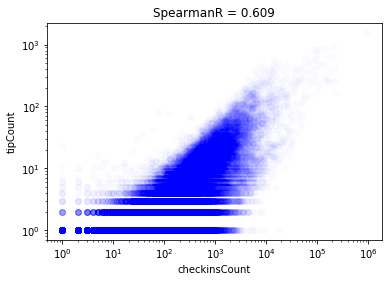

In [4]:
from scipy.stats import spearmanr

def getDistribution(keys, normalized = True):
    
    uniq_keys = np.unique(keys)
    bins = uniq_keys.searchsorted(keys)
    distr = np.bincount(bins) 

    if normalized == 1: distr = distr/float(np.sum(distr)) 

    return np.asarray(uniq_keys.tolist()), np.asarray(distr.tolist())


x, y = getDistribution(success.checkinsCount)
plt.title('SpearmanR = ' + str(round(spearmanr(success.checkinsCount, success.tipCount)[0], 3)))
plt.xlabel('checkinsCount')
plt.ylabel('tipCount')
plt.xscale('log')
plt.yscale('log')
plt.plot(success.checkinsCount, success.tipCount, 'bo', alpha = 0.01)




### Get success features

In [6]:
# basic stats of wards: bbox, length, area

outfolder    = '../ProcessedData/' + city + '/'
ward_stats_f = outfolder + 'venues_info/venues_ward_full.dat'
ward_stats   = pd.read_csv(ward_stats_f, sep = '\t', index_col = 0).drop(['ward'], axis=1)
ward_stats.head()

,lng,lat,lng0,lat0,lng1,lat1,length,area
venue,,,,,,,,
4ed012c26c2510ace08f6196,-0.148227,51.506406,-0.158366,51.501861,-0.128997,51.520817,0.085100,0.000259
5131bfc3e4b021182eb750c3,-0.116914,51.540017,-0.126362,51.530726,-0.110892,51.548216,0.057344,0.000147
54075d1f498e92eeef450c56,-0.134685,51.513940,-0.158366,51.501861,-0.128997,51.520817,0.085100,0.000259
5214b8fb11d2f8576bfde883,-0.097689,51.373167,-0.107011,51.362173,-0.063469,51.382757,0.130389,0.000487
5260ef75498eda1e8cbc86b2,-0.117076,51.518833,-0.130472,51.512652,-0.105350,51.525517,0.073794,0.000155


In [32]:
# category stats of wards: number of venues, fraction of food, nightlife..., entropy

ward_cats_f  = outfolder + 'venues_info/' + city + '_WARD_category_stats.csv'
ward_cats    = pd.read_csv(ward_cats_f, sep = '\t', index_col = 0).drop(['ward'], axis=1)
ward_cats.head()

ward_cats.Entropy

4a5f9446f964a520e0bf1fe3    4228.556635
4abcec53f964a520b98720e3    4271.529960
4abdc1c7f964a5206d8b20e3    4240.898536
4abe4502f964a520558c20e3    4271.529960
4abe5714f964a520d68c20e3    4268.066031
4abf8c03f964a520079120e3    4078.348099
4ac3ba25f964a520919c20e3    4112.259278
4ac4bb54f964a520e49e20e3    4268.066031
4ac51183f964a52045a020e3    4268.066031
4ac51183f964a52046a020e3    4260.591659
4ac51183f964a52048a020e3    4052.410390
4ac51183f964a52049a020e3    4219.195983
4ac51183f964a5204aa020e3    4170.095670
4ac51183f964a5204ca020e3    4268.066031
4ac518b4f964a52064a020e3    4268.066031
4ac518b4f964a52065a020e3    4179.371939
4ac518b4f964a52066a020e3    4078.348099
4ac518b4f964a52067a020e3    4271.529960
4ac518b4f964a52068a020e3    4271.529960
4ac518b4f964a5206ba020e3    4268.066031
4ac518b4f964a5206fa020e3    4133.989362
4ac518b4f964a52071a020e3    4078.348099
4ac518b4f964a52072a020e3    4268.066031
4ac518b4f964a52073a020e3    4133.989362
4ac518b4f964a52075a020e3    4248.281723


In [8]:
# venue similarity network stuff with threshold (1000 for now) 
# and
# user friendship network measures aggregated on the venue level

network_meas_f  = outfolder + '/networks/' + city + '_COMBINED_networkmeasures.csv'
network_meas    = pd.read_csv(network_meas_f, sep = ',', index_col = 0).replace([np.inf, -np.inf], np.nan).fillna(0.0)
network_meas.head()

,u_pagerank_geo_avg,u_eigenvector_avg,u_pagerank_geo_std,u_degree_avg,u_closeness_entropy,u_degree_std,u_strength_geo_avg,u_pagerank_geo_entropy,u_closeness_std,u_betweenness_std,...,v_pagerank_w,v_clustering_w,v_constraint_geo,v_clustering_geo,v_betweenness_w,v_constraint,v_egosize,v_geo_stdev_of_ego,v_eigenvector,v_social_stretch
4a5f9446f964a520e0bf1fe3,1.211112e-06,0.000259,1.218646e-06,0.275000,1.000000,0.670354,1.763914,0.900191,5.227823e-08,7825.375658,...,0.000015,0.088889,0.353291,0.097853,98850.989424,0.245556,6.0,1.06707,3.790920e-11,7.223221
4abcec53f964a520b98720e3,2.473126e-06,0.001194,2.606565e-06,0.923077,0.989274,1.707969,4.438957,0.865689,1.154123e-05,26425.541908,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000e+00,0.000000
4abdc1c7f964a5206d8b20e3,4.881170e-07,0.000249,7.030505e-07,0.067669,0.998622,0.328942,0.976730,0.885992,1.013314e-06,5703.073122,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000e+00,0.000000
4abe4502f964a520558c20e3,5.597751e-08,0.000018,9.229690e-08,0.000000,0.997246,0.000000,0.093386,0.909593,2.670204e-07,673.549573,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000e+00,0.000000
4abe5714f964a520d68c20e3,7.961964e-07,0.000269,7.754698e-07,0.098361,0.989077,0.297802,1.324720,0.910106,5.527000e-06,5555.302564,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000e+00,0.000000


In [9]:
### full feature set

#print network_meas.head()
#print ward_cats.head()
#print ward_stats.head()

temp = network_meas.join(ward_cats)
venue_features = temp.join(ward_stats)




### Drop shitty features

In [31]:
# dropping weak features keeping good ones
ok_feats = ['social_stretch_std', 'social_stretch_entropy', 'constraint_std', 'constraint_entropy', 'egosize_std', 'closeness_entropy', 'social_stretch_entropy', 'egosize_entropy', 'geo_size_of_ego_entropy', 'pagerank_geo_entropy', 'closeness_geo_entropy', 'constraint_std', 'constraint_geo_entropy', 'constraint_entropy', 'degree_entropy', 'constraint_geo_std']
ok_feats = ['u_' + o for o in ok_feats] + ['Venues_num']

filtered_features = filtered_features[~filtered_features.index.duplicated(keep='first')]   


filtered_features = pd.DataFrame()
for feat in venue_features.keys():
    if 'u_' in feat:
        filtered_features[feat] = venue_features[feat]

filtered_features = filtered_features[~filtered_features.index.duplicated(keep='first')]   
print len(filtered_features.keys())

# dropping zeros
filtered_features.head()

#print len(filtered_features['closeness_entropy'])


for feat in ok_feats:
    filtered_features = filtered_features[filtered_features[feat] != 0.0]    


#print len(filtered_features['closeness_entropy'])



54


KeyError: 'Venues_num'

# REGRESSION CODE

In [13]:
# preproc the features

X_head = filtered_features.keys()
X      = filtered_features.values
X      = StandardScaler().fit_transform(X)
X      = preprocessing.quantile_transform(X, output_distribution = 'normal')



35438


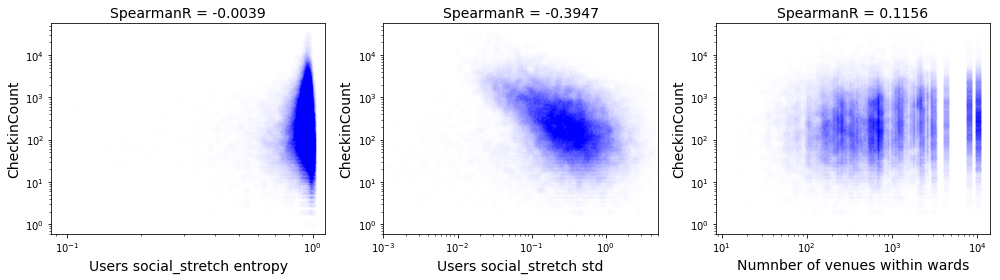

In [28]:
# preproc the target
success_t = success.reset_index()
success_t = success_t[success_t['index'].isin(list(filtered_features.index)) ]

y = np.asarray(success_t['checkinsCount'])
y = StandardScaler().fit_transform(y.reshape(-1, 1) )
y = preprocessing.quantile_transform(y, output_distribution = 'normal')


#plt.hist(y, bins = 40)
print len(filtered_features.index)




f, ax = plt.subplots(1, 3, figsize=(14, 4))




ego = filtered_features['u_social_stretch_entropy']

ven = filtered_features['Venues_num']
checkin = success_t.checkinsCount

ax[0].set_title('SpearmanR = '+str(round(spearmanr(checkin, ego)[0],4)), fontsize = 14)
ax[0].set_ylabel('CheckinCount', fontsize = 14)
ax[0].set_xlabel('Users social_stretch entropy', fontsize = 14)
ax[0].plot(ego, checkin, 'bo', alpha = 0.005)
ax[0].set_yscale('log')


ego = filtered_features['u_social_stretch_std']
ax[1].set_title('SpearmanR = '+str(round(spearmanr(checkin, ego)[0],4)), fontsize = 14)
ax[1].set_ylabel('CheckinCount', fontsize = 14)
ax[1].set_xlabel('Users social_stretch std', fontsize = 14)
ax[1].plot( ego,checkin, 'bo', alpha = 0.005)
ax[1].set_yscale('log')
#ax[1].set_xscale('log')
#ax[1].set_xlim

ego = filtered_features['u_egosize_std']
ax[2].set_title('SpearmanR = '+str(round(spearmanr(checkin, ven)[0],4)), fontsize = 14)
ax[2].set_ylabel('CheckinCount', fontsize = 14)
ax[2].set_xlabel('Numnber of venues within wards', fontsize = 14)
ax[2].plot(ven, checkin, 'bo', alpha = 0.005)
ax[2].set_yscale('log')
ax[2].set_xscale('log')
ax[1].set_xscale('log')
ax[0].set_xscale('log')

ax[1].set_xlim([0.9, 1.2])

ax[1].set_xlim([0.001, 5])

plt.tight_layout()

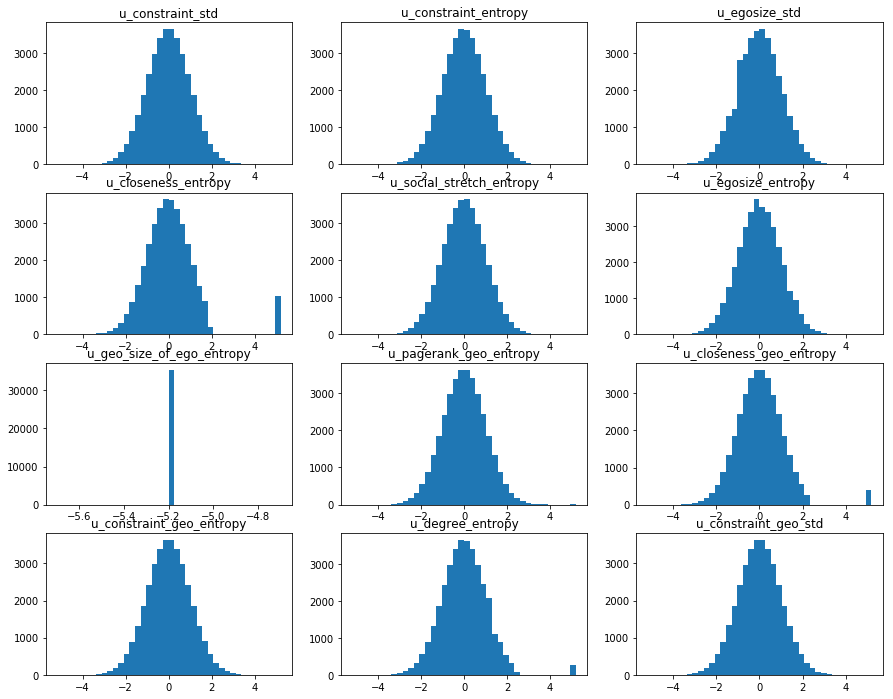

In [15]:

fig, axes = plt.subplots(4, 3, figsize=(15, 12))
for i, ax in enumerate(axes.ravel()):
    if i > 75:
        ax.set_visible(False)
        continue
    ax.hist(X[:,i], bins = 40)
    #ax.plot(X_sc[:, i], y, 'o', alpha=.05)
    ax.set_title(X_head[i])

## Linear Regression


*** https://www.analyticsvidhya.com/blog/2016/01/complete-tutorial-ridge-lasso-regression-python/ ***

In [65]:
from sklearn import linear_model
from scipy import stats

class LinearRegression(linear_model.LinearRegression):
    """
    LinearRegression class after sklearn's, but calculate t-statistics and p-values for model coefficients (betas).
    Additional attributes available after .fit() are `t` and `p` which are of the shape (y.shape[1], X.shape[1])
    which is (n_features, n_coefs) This class sets the intercept to 0 by default, since usually we include it  in X.
    """
    def __init__(self, fit_intercept=True, normalize=False, copy_X=True,
                 n_jobs=1):
        self.fit_intercept = fit_intercept
        self.normalize = normalize
        self.copy_X = copy_X
        self.n_jobs = n_jobs

    def fit(self, X, y, n_jobs=1):
        self = super(LinearRegression, self).fit(X, y, n_jobs)
        
        sse = np.sum((self.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
        
        #print sse
        se = np.array([np.sqrt(np.diagonal(sse * np.linalg.inv(np.dot(X.T, X))))])
        #se  = np.array([np.sqrt(np.diagonal(sse[i] * np.linalg.inv(np.dot(X.T, X)))) for i in range(sse.shape[0])])

        self.t = self.coef_ / se
        self.p = 2 * (1 - stats.t.cdf(np.abs(self.t), y.shape[0] - X.shape[1]))
        return self

In [66]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

In [67]:
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

In [68]:
# Create linear regression object
linear_regressor = LinearRegression()

# Train the model using the training sets
res = linear_regressor.fit(X_train, y_train)

# The coefficients

#print('Coefficients: \n', linear_regressor.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, linear_regressor.predict(X_test)))
# Explained variance score: 1 is perfect prediction
print('R^2 (training): %f' % r2_score(y_train, linear_regressor.predict(X_train)))
print('R^2 (testing):  %f' % r2_score(y_test, linear_regressor.predict(X_test))), '\n'

#for i in range(len(linear_regressor.p)):
    #print(linear_regressor.coef_[0][i], linear_regressor.p[i] , '\n')
    
for i in range(len(linear_regressor.coef_[0])):
    print X_head[i], '\t\tcoeff = ', linear_regressor.coef_[0][i], '\t p = ',linear_regressor.p[0][i]
    


Mean squared error: 0.54
R^2 (training): 0.470877
R^2 (testing):  0.466438 

u_constraint_std 		coeff =  0.045343343063083005 	 p = 

AttributeError: 'LinearRegression' object has no attribute 'p'

### Plotting Cross-Validated Predictions

In [ ]:
# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:
predicted = cross_val_predict(linear_regressor, X, y, cv=5)

fig, ax   = plt.subplots()
ax.scatter(y, predicted, edgecolors=(0, 0, 0), alpha = 0.8)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
#ax.set_yscale('log')
#ax.set_xscale('log')                                                                                                
#ax.set_ylim([1, 200000])
#ax.set_xlim([1, 200000])
plt.show()


In [ ]:
results = cross_val_score(linear_regressor, X_train, y_train, cv=10)
print(results)
print("mean: ", np.mean(results))


In [ ]:
''' FULL REGERSSION IN ONE'''

### Learning curve

In [ ]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(est, X, y):
    training_set_size, train_scores, test_scores = learning_curve(est, X, y, train_sizes=np.linspace(.1, 1, 20))
    estimator_name = est.__class__.__name__
    line = plt.plot(training_set_size, train_scores.mean(axis=1), '--', label="training scores " + estimator_name)
    plt.plot(training_set_size, test_scores.mean(axis=1), '-', label="test scores " + estimator_name, c=line[0].get_color())
    plt.xlabel('Training set size')
    plt.legend(loc='best')
    plt.ylim(-0.1, 1.1)

plt.figure()   
plot_learning_curve(LinearRegression(), X_train, y_train)


# Ridge Regression (L2 penalty)


In [ ]:
# Create linear regression object
ridge_regressor = Ridge()

# Train the model using the training sets
ridge_regressor.fit(X_train, y_train)

# The coefficients
print('Coefficients: \n', ridge_regressor.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, ridge_regressor.predict(X_test)))
# Explained variance score: 1 is perfect prediction
print('R^2 (training): %f' % r2_score(y_train, ridge_regressor.predict(X_train)))
print('R^2 (testing): %f' % r2_score(y_test, ridge_regressor.predict(X_test)))

### Tuning the hyperparameter alpha

In [ ]:
ridge_models = {}
training_scores = []
test_scores = []

for alpha in [100, 10, 1, .01]:
    ridge = Ridge(alpha=alpha).fit(X_train, y_train)
    training_scores.append(ridge.score(X_train, y_train))
    test_scores.append(ridge.score(X_test, y_test))
    ridge_models[alpha] = ridge

plt.figure()
plt.plot(training_scores, label="training scores")
plt.plot(test_scores, label="test scores")
plt.xticks(range(4), [100, 10, 1, .01])
plt.ylim([0,1])
plt.legend(loc="best")

In [ ]:
plt.figure()
plot_learning_curve(LinearRegression(), X, y)
plot_learning_curve(Ridge(alpha=10), X, y)

### Using GridSearchCV to set the best alpha 

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {'alpha': np.logspace(-3, 3, 14)}
print(param_grid)

grid_search = GridSearchCV(Ridge(), param_grid, cv=10, return_train_score=True)
grid_search.fit(X_train, y_train)

print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))

print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
print("Best estimator:\n{}".format(grid_search.best_estimator_))
print('Accuracy on the testing set: {:.4f}'.format(grid_search.best_estimator_.score(X_test, y_test)))

In [ ]:
import pandas as pd
results = pd.DataFrame(grid_search.cv_results_)
results.plot('param_alpha', 'mean_train_score', ax=plt.gca())
results.plot('param_alpha', 'mean_test_score', ax=plt.gca())

plt.ylim([0,1])
plt.legend()
plt.xscale("log")

## Lasso (L1 penalty)

In [ ]:
param_grid = {'alpha': np.logspace(-1.5, 0, 14)}

print(param_grid)

grid_search = GridSearchCV(Lasso(), param_grid, cv=10, return_train_score=True)
grid_search.fit(X_train, y_train)

print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))

print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
print("Best estimator:\n{}".format(grid_search.best_estimator_))
print('Accuracy on the testing set: {:.4f}'.format(grid_search.best_estimator_.score(X_test, y_test)))

# Robust models

In [ ]:
 HuberRegressor, RANSACRegressor

